In [1]:
# Copyright (c) Liuhao Ge. All Rights Reserved.
r"""
Basic evaluation script for PyTorch
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import argparse
import os.path as osp
import torch
import numpy as np
import cv2

from hand_shape_pose.config import cfg
from hand_shape_pose.model.shape_pose_network import ShapePoseNetwork
from hand_shape_pose.data.build import build_dataset

from hand_shape_pose.util.logger import setup_logger, get_logger_filename
from hand_shape_pose.util.miscellaneous import mkdir
from hand_shape_pose.util.vis import save_batch_image_with_mesh_joints
from hand_shape_pose.util import renderer

In [2]:
parser = argparse.ArgumentParser(description="3D Hand Shape and Pose Inference")
parser.add_argument(
        "--config-file",
        default="configs/eval_real_world_testset.yaml",
        metavar="FILE",
        help="path to config file",
)
parser.add_argument(
        "opts",
        help="Modify config options using the command-line",
        default=None,
        nargs=argparse.REMAINDER,
)

_StoreAction(option_strings=[], dest='opts', nargs='...', const=None, default=None, type=None, choices=None, help='Modify config options using the command-line', metavar=None)

In [3]:
# command_str = "--config-file configs/eval_real_world_testset.yaml"
args = parser.parse_args("")

In [4]:
args

Namespace(config_file='configs/eval_real_world_testset.yaml', opts=[])

In [5]:
cfg.merge_from_file(args.config_file)
cfg.merge_from_list(args.opts)
cfg.freeze()

In [6]:
output_dir = osp.join(cfg.EVAL.SAVE_DIR, args.config_file)
mkdir(output_dir)
logger = setup_logger("hand_shape_pose_inference", output_dir, filename='eval-' + get_logger_filename())
logger.info(cfg)

2021-03-26 14:57:57,951 hand_shape_pose_inference INFO: EVAL:
  DATASET: real_world_testset
  PRINT_FREQ: 5
  SAVE_BATCH_IMAGES_PRED: True
  SAVE_DIR: ./output
  SAVE_POSE_ESTIMATION: True
GRAPH:
  TEMPLATE_PATH: ./data/0214_lowP_vn_g.0001.obj
MODEL:
  BATCH_SIZE: 8
  DEVICE: cuda:0
  HOURGLASS:
    NUM_FEAT_CHANNELS: 256
    NUM_MODULES: 2
    NUM_STAGES: 2
  NUM_JOINTS: 21
  NUM_WORKERS: 4
  PRETRAIN_WEIGHT:
    HM_NET_PATH: ./model/pretrained_models/net_hm.pth
    MESH_NET_PATH: ./model/pretrained_models/net_feat_mesh.pth
    POSE_NET_PATH: ./model/pretrained_models/net_mesh_pose.pth


In [7]:
# 1. Load network model
model = ShapePoseNetwork(cfg, output_dir)
device = cfg.MODEL.DEVICE
model.to(device)
model.load_model(cfg)

loading mesh triangles
2021-03-26 14:58:00,887 hand_shape_pose_inference INFO: Load saved graph from ./output/configs/eval_real_world_testset.yaml/graph_dict.npy.
2021-03-26 14:58:00,890 hand_shape_pose_inference INFO: Layer 0: M_0 = |V| = 1280 nodes, |E| = 2845 edges
2021-03-26 14:58:00,890 hand_shape_pose_inference INFO: Layer 1: M_1 = |V| = 640 nodes, |E| = 1734 edges
2021-03-26 14:58:00,891 hand_shape_pose_inference INFO: Layer 2: M_2 = |V| = 320 nodes, |E| = 932 edges
2021-03-26 14:58:00,891 hand_shape_pose_inference INFO: Layer 3: M_3 = |V| = 160 nodes, |E| = 490 edges
2021-03-26 14:58:00,892 hand_shape_pose_inference INFO: Layer 4: M_4 = |V| = 80 nodes, |E| = 267 edges
2021-03-26 14:58:00,955 hand_shape_pose_inference INFO: lmax: [1.5350166960729197, 1.3921939856604175, 1.1495376588217792, 1.0082155947886449]
Graph ConvNet: feature to mesh
Graph ConvNet: mesh to pose


In [8]:
mesh_renderer = renderer.MeshRenderer(model.hand_tri.astype('uint32'))

In [9]:
cfg.EVAL.DATASET

'real_world_testset'

In [10]:
# 2. Load data
dataset_val = build_dataset(cfg.EVAL.DATASET)
data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=cfg.MODEL.BATCH_SIZE,
        num_workers=cfg.MODEL.NUM_WORKERS
)

In [11]:
# 3. Inference
model.eval()
results_pose_cam_xyz = {}
cpu_device = torch.device("cuda:0")
logger.info("Evaluate on {} frames:".format(len(dataset_val)))

2021-03-26 14:58:03,931 hand_shape_pose_inference INFO: Evaluate on 583 frames:


In [12]:
for i, batch in enumerate(data_loader_val):
    batch_data = batch
    break

In [13]:
images, cam_params, bboxes, pose_roots, pose_scales, image_ids = batch_data

In [14]:
images, cam_params, bboxes, pose_roots, pose_scales = \
    images.to(device), cam_params.to(device), bboxes.to(device), pose_roots.to(device), pose_scales.to(device)

In [15]:
with torch.no_grad():
    est_mesh_cam_xyz, est_pose_uv, est_pose_cam_xyz = \
        model(images, cam_params, bboxes, pose_roots, pose_scales)
    
    est_mesh_cam_xyz = None
    est_pose_uv = [o.to(cpu_device) for o in est_pose_uv]
    est_pose_cam_xyz = [o.to(cpu_device) for o in est_pose_cam_xyz]
    
# results_pose_cam_xyz.update({img_id.item(): result for img_id, result in zip(image_ids, est_pose_cam_xyz)})

/home/yudzyoga/.virtualenvs/handgesture/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [16]:
results_pose_cam_xyz

{}

In [17]:
if i % cfg.EVAL.PRINT_FREQ == 0:
    # 4. evaluate pose estimation
    avg_est_error = dataset_val.evaluate_pose(results_pose_cam_xyz, save_results=False)  # cm
    msg = 'Evaluate: [{0}/{1}]\t' 'Average pose estimation error: {2:.2f} (mm)'.format(
                len(results_pose_cam_xyz), len(dataset_val), avg_est_error * 10.0)
    logger.info(msg)
    
    if i % cfg.EVAL.PRINT_FREQ == 0:
        # 4. evaluate pose estimation
        avg_est_error = dataset_val.evaluate_pose(results_pose_cam_xyz, save_results=False)  # cm
        msg = 'Evaluate: [{0}/{1}]\t' 'Average pose estimation error: {2:.2f} (mm)'.format(
                len(results_pose_cam_xyz), len(dataset_val), avg_est_error * 10.0)
        logger.info(msg)
        save_batch_image_with_mesh_joints(mesh_renderer, images.to(cpu_device), cam_params.to(cpu_device),
                                                  bboxes.to(cpu_device), est_mesh_cam_xyz, est_pose_uv,
                                                  est_pose_cam_xyz, file_name)

ZeroDivisionError: float division by zero

In [18]:
# overall evaluate pose estimation
assert len(results_pose_cam_xyz) == len(dataset_val), \
        "The number of estimation results (%d) is inconsistent with that of the ground truth (%d)." % \
        (len(results_pose_cam_xyz), len(dataset_val))

avg_est_error = dataset_val.evaluate_pose(results_pose_cam_xyz, cfg.EVAL.SAVE_POSE_ESTIMATION, output_dir)  # cm
logger.info("Overall:\tAverage pose estimation error: {0:.2f} (mm)".format(avg_est_error * 10.0))


AssertionError: The number of estimation results (0) is inconsistent with that of the ground truth (583).

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

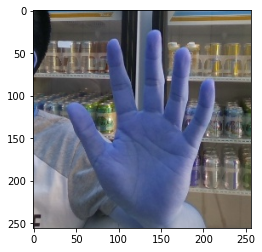

In [20]:
img = np.array(images[0].cpu())
plt.imshow(img)

In [97]:
est_pose_uv

[tensor([[142., 229.],
         [105., 206.],
         [ 78., 170.],
         [ 61., 138.],
         [ 46., 114.],
         [114., 137.],
         [101.,  86.],
         [ 97.,  65.],
         [ 93.,  37.],
         [141., 142.],
         [141.,  85.],
         [138.,  53.],
         [141.,  26.],
         [162., 153.],
         [169., 105.],
         [173.,  73.],
         [178.,  46.],
         [185., 158.],
         [198., 126.],
         [205., 106.],
         [206.,  85.]], device='cuda:0'),
 tensor([[141., 226.],
         [106., 206.],
         [ 82., 170.],
         [ 62., 141.],
         [ 46., 117.],
         [117., 137.],
         [102.,  89.],
         [ 97.,  66.],
         [ 93.,  38.],
         [141., 142.],
         [141.,  85.],
         [141.,  54.],
         [142.,  29.],
         [165., 153.],
         [170., 105.],
         [174.,  74.],
         [178.,  46.],
         [185., 161.],
         [198., 129.],
         [205., 109.],
         [209.,  86.]], device='cuda:0

In [21]:
for uv in est_pose_uv[0]:
    u, v = int(uv[0].item()), int(uv[1].item()) 
    cv2.circle(img, (u, v), 5, (255, 0, 0), 2)

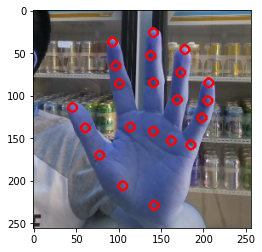

In [22]:
plt.imshow(img)

In [96]:
est_pose_cam_xyz[0]

tensor([[ 0.4186, 11.0176, 42.4296],
        [-2.6314,  9.0239, 42.0210],
        [-5.0671,  5.9526, 42.6109],
        [-6.5485,  3.0963, 42.4233],
        [-7.8630,  0.9722, 42.3572],
        [-1.8652,  3.0154, 42.5288],
        [-2.9517, -1.4733, 41.5964],
        [-3.2090, -3.2048, 40.4659],
        [-3.4425, -5.4038, 39.2801],
        [ 0.5228,  3.4181, 42.0299],
        [ 0.5018, -1.5131, 40.3457],
        [ 0.2406, -4.0562, 38.9213],
        [ 0.4688, -6.0502, 37.6955],
        [ 2.2961,  4.2579, 40.8404],
        [ 2.7571,  0.1631, 38.9330],
        [ 2.9379, -2.3205, 37.1154],
        [ 3.1876, -4.2276, 35.5830],
        [ 4.0999,  4.5133, 39.3557],
        [ 4.9027,  1.7914, 37.3450],
        [ 5.2182,  0.2245, 35.7714],
        [ 5.0858, -1.2891, 34.3727]], device='cuda:0')

In [23]:
def save_batch_image_with_mesh_joints(mesh_renderer, batch_images, cam_params, bboxes,
                                      est_mesh_cam_xyz, est_pose_uv, est_pose_cam_xyz,
                                      file_name, padding=2):
    """
    :param mesh_renderer:
    :param batch_images: B x H x W x 3 (torch.Tensor)
    :param cam_params: B x 4 (torch.Tensor)
    :param bboxes: B x 4 (torch.Tensor)
    :param est_mesh_cam_xyz: B x 1280 x 3 (torch.Tensor)
    :param est_pose_uv: B x 21 x 2 (torch.Tensor)
    :param est_pose_cam_xyz: B x 21 x 3 (torch.Tensor)
    :param file_name:
    :param padding:
    :return:
    """
    num_images = batch_images.shape[0]
    image_height = batch_images.shape[1]
    image_width = batch_images.shape[2]
    num_column = 6

    grid_image = np.zeros((num_images * (image_height + padding), num_column * (image_width + padding), 3),
                          dtype=np.uint8)

    for id_image in range(num_images):
        image = batch_images[id_image].cpu().numpy()
        cam_param = cam_params[id_image].cpu().numpy()
        box = bboxes[id_image].cpu().numpy()
        # mesh_xyz = est_mesh_cam_xyz[id_image].cpu().numpy()
        pose_uv = est_pose_uv[id_image].cpu().numpy()
        pose_xyz = est_pose_cam_xyz[id_image].cpu().numpy()

        # rend_img_overlay, rend_img_vp1, rend_img_vp2 = draw_mesh(mesh_renderer, image, cam_param, box, mesh_xyz)
        skeleton_overlay = draw_2d_skeleton(image, pose_uv)
        skeleton_3d = draw_3d_skeleton(pose_xyz, image.shape[:2])

        img_list = [image, skeleton_overlay, skeleton_3d]

        height_begin = (image_height + padding) * id_image
        height_end = height_begin + image_height
        width_begin = 0
        width_end = image_width
        for show_img in img_list:
            grid_image[height_begin:height_end, width_begin:width_end, :] = show_img[..., :3]
            width_begin += (image_width + padding)
            width_end = width_begin + image_width
    
    plt.imshow(grid_image)
#     cv2.imwrite(file_name, grid_image)

### Try bbox

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
images, cam_params, bboxes, pose_roots, pose_scales, image_ids = batch_data

In [26]:
def uvd2xyzi(uvd, cam_param, bbox, root_depth, pose_scale):
    """
    :param uvd: B x M x 3 (uvd is normalized between 0~1)
    :param cam_param: B x 4, [fx, fy, u0, v0]
    :param bbox: B x 4, bounding box in the original image, [x, y, w, h]
    :param root_depth: B
    :param pose_scale: B
    :return: mesh xyz coordinates in camera coordinate system, B x M x 3
    """
    '''1. denormalized uvd'''
    bbox = bbox.unsqueeze(1).expand(-1, uvd.size(1), -1)  # B x M x 4
    uv = uvd[:, :, :2] * bbox[:, :, 2:4] + bbox[:, :, :2]  # B x M x 2

    depth = uvd[:, :, 2] * pose_scale.unsqueeze(-1).expand_as(uvd[:, :, 2]) \
            + root_depth.unsqueeze(-1).expand_as(uvd[:, :, 2])  # B x M

    '''2. uvd->xyz'''
    cam_param = cam_param.unsqueeze(1).expand(-1, uvd.size(1), -1)  # B x M x 4
    xy = ((uv - cam_param[:, :, 2:4]) / cam_param[:, :, :2]) * depth.unsqueeze(-1).expand_as(uv)  # B x M x 2

    return torch.cat((xy, depth.unsqueeze(-1)), -1)  # B x M x 3

In [27]:
images[0].shape

torch.Size([256, 256, 3])

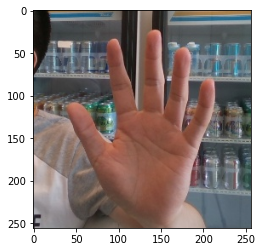

In [28]:
tar_img = cv2.cvtColor(np.array(images[0]), cv2.COLOR_BGR2RGB)
img = np.array(tar_img)
plt.imshow(img)

In [29]:
input_img = torch.Tensor(img).reshape(1, 256, 256, 3).to(device)

In [30]:
from hand_shape_pose.util.image_util import BHWC_to_BCHW, normalize_image, uvd2xyz

In [31]:
num_sample = input_img.shape[0]
root_depth = pose_roots[:, -1][0].to(device)
images = BHWC_to_BCHW(input_img)  # B x C x H x W
images = normalize_image(images)

cam_param = cam_params[0].to(device)
bbox = bboxes[0].to(device)
pose_scale = pose_scales[0].to(device)

In [32]:
# 1. Heat-map estimation
est_hm_list, encoding = model.net_hm(images)

In [52]:
# 2. Mesh estimation
# 2.1 Mesh uvd estimation
est_mesh_uvd = model.net_feat_mesh(est_hm_list, encoding)  # B x V x 3
est_mesh_uvd = est_mesh_uvd * model.graph_mask.unsqueeze(0).expand_as(est_mesh_uvd)  # B x V x 3
# 2.2 convert to mesh xyz in camera coordiante system
est_mesh_cam_xyz = uvd2xyzi(est_mesh_uvd, cam_param.reshape(1, 4), bbox.reshape(1, 4), root_depth.reshape(1), pose_scale.reshape(1))  # B x V x 3
est_mesh_cam_xyz = est_mesh_cam_xyz * model.graph_mask.unsqueeze(0).expand_as(est_mesh_cam_xyz)  # B x V x 3

In [53]:
est_mesh_cam_xyz.shape

torch.Size([1, 1280, 3])

In [54]:
from hand_shape_pose.util.heatmap_util import compute_uv_from_heatmaps

In [55]:
input_img.shape[1:3]

torch.Size([256, 256])

In [111]:
# combine heat-map estimation results to compute pose xyz in camera coordiante system
est_pose_uv = compute_uv_from_heatmaps(est_hm_list[-1], input_img.shape[1:3])  # B x K x 3
est_pose_uvd = torch.cat((est_pose_uv[:, 1:, :2], est_pose_rel_depth[:, :, -1].unsqueeze(-1)), -1)  # B x (K-1) x 3
        
est_pose_uvd[:, :, 0] = est_pose_uvd[:, :, 0] / float(input_img.shape[2])
est_pose_uvd[:, :, 1] = est_pose_uvd[:, :, 1] / float(input_img.shape[3])
est_pose_cam_xyz = uvd2xyz(est_pose_uvd, cam_param.reshape(1, 4), bbox.reshape(1, 4), root_depth.reshape(1), pose_scale.reshape(1))  # B x (K-1) x 3
est_pose_cam_xyz = torch.cat((pose_roots[0].reshape(1, 3).unsqueeze(1).to(device), est_pose_cam_xyz), 1)  # B x K x 3

In [58]:
color_hand_joints = [[1.0, 0.0, 0.0],
                     [0.0, 0.4, 0.0], [0.0, 0.6, 0.0], [0.0, 0.8, 0.0], [0.0, 1.0, 0.0],  # thumb
                     [0.0, 0.0, 0.6], [0.0, 0.0, 1.0], [0.2, 0.2, 1.0], [0.4, 0.4, 1.0],  # index
                     [0.0, 0.4, 0.4], [0.0, 0.6, 0.6], [0.0, 0.8, 0.8], [0.0, 1.0, 1.0],  # middle
                     [0.4, 0.4, 0.0], [0.6, 0.6, 0.0], [0.8, 0.8, 0.0], [1.0, 1.0, 0.0],  # ring
                     [0.4, 0.0, 0.4], [0.6, 0.0, 0.6], [0.8, 0.0, 0.8], [1.0, 0.0, 1.0]]  # little



In [59]:
def fig2dataa(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    return buf

In [60]:
def draw_3d_skeleton_on_ax(pose_cam_xyz, ax):
    """
    :param pose_cam_xyz: 21 x 3
    :param ax:
    :return:
    """
    assert pose_cam_xyz.shape[0] == 21

    marker_sz = 15
    line_wd = 2

    for joint_ind in range(pose_cam_xyz.shape[0]):
        ax.plot(pose_cam_xyz[joint_ind:joint_ind + 1, 0], pose_cam_xyz[joint_ind:joint_ind + 1, 1],
                pose_cam_xyz[joint_ind:joint_ind + 1, 2], '.', c=color_hand_joints[joint_ind], markersize=marker_sz)
        if joint_ind == 0:
            continue
        elif joint_ind % 4 == 1:
            ax.plot(pose_cam_xyz[[0, joint_ind], 0], pose_cam_xyz[[0, joint_ind], 1], pose_cam_xyz[[0, joint_ind], 2],
                    color=color_hand_joints[joint_ind], linewidth=line_wd)
        else:
            ax.plot(pose_cam_xyz[[joint_ind - 1, joint_ind], 0], pose_cam_xyz[[joint_ind - 1, joint_ind], 1],
                    pose_cam_xyz[[joint_ind - 1, joint_ind], 2], color=color_hand_joints[joint_ind],
                    linewidth=line_wd)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=-85, azim=-75)

In [61]:
def draw_3d_skeleton(pose_cam_xyz, image_size):
    """
    :param pose_cam_xyz: 21 x 3
    :param image_size: H, W
    :return:
    """
    fig = plt.figure()
    fig.set_size_inches(float(image_size[0]) / fig.dpi, float(image_size[1]) / fig.dpi, forward=True)
    ax = plt.subplot(111, projection='3d')
    draw_3d_skeleton_on_ax(pose_cam_xyz, ax)

    ret = fig2dataa(fig)  # H x W x 4
    plt.close(fig)
    return ret

In [62]:
def draw_2d_skeleton(image, pose_uv):
    """
    :param image: H x W x 3
    :param pose_uv: 21 x 2
    wrist,
    thumb_mcp, thumb_pip, thumb_dip, thumb_tip
    index_mcp, index_pip, index_dip, index_tip,
    middle_mcp, middle_pip, middle_dip, middle_tip,
    ring_mcp, ring_pip, ring_dip, ring_tip,
    little_mcp, little_pip, little_dip, little_tip
    :return:
    """
    assert pose_uv.shape[0] == 21
    skeleton_overlay = np.copy(image)

    marker_sz = 6
    line_wd = 3
    root_ind = 0

    for joint_ind in range(pose_uv.shape[0]):
        joint = pose_uv[joint_ind, 0].astype('int32'), pose_uv[joint_ind, 1].astype('int32')
        cv2.circle(
            skeleton_overlay, joint,
            radius=marker_sz, color=color_hand_joints[joint_ind] * np.array(255), thickness=-1,
            lineType=cv2.CV_AA if cv2.__version__.startswith('2') else cv2.LINE_AA)

        if joint_ind == 0:
            continue
        elif joint_ind % 4 == 1:
            root_joint = pose_uv[root_ind, 0].astype('int32'), pose_uv[root_ind, 1].astype('int32')
            cv2.line(
                skeleton_overlay, root_joint, joint,
                color=color_hand_joints[joint_ind] * np.array(255), thickness=int(line_wd),
                lineType=cv2.CV_AA if cv2.__version__.startswith('2') else cv2.LINE_AA)
        else:
            joint_2 = pose_uv[joint_ind - 1, 0].astype('int32'), pose_uv[joint_ind - 1, 1].astype('int32')
            cv2.line(
                skeleton_overlay, joint_2, joint,
                color=color_hand_joints[joint_ind] * np.array(255), thickness=int(line_wd),
                lineType=cv2.CV_AA if cv2.__version__.startswith('2') else cv2.LINE_AA)

    return skeleton_overlay

In [80]:
pose_xyz.shape

(21, 3)

In [112]:
pose_uv = est_pose_uv[0].detach().cpu().numpy()
pose_xyz = est_pose_cam_xyz[0].detach().cpu().numpy()

In [157]:
temp_pose_mcp = [0, 0, 0]
temp_pose_pip = [0, 0, 0]
for i in range(5, 20, 4):
    temp_pose_mcp += pose_xyz[i]
    temp_pose_pip += pose_xyz[i+1]
diff = (0.25 * (temp_pose_pip - temp_pose_mcp))
pose_xyz[0] = (0.25 * temp_pose_mcp) - 2 * diff
# pose_xyz[0][1:3] = (0.25 * temp_pose_mcp[1:3]) + 2 * diff[1:3]

In [153]:
temp_pose_pip * 0.25

array([  1.24112773, 696.12234497,  39.6679287 ])

In [154]:
temp_pose_mcp * 0.25

array([   1.18256445, 1078.55007935,   41.29110432])

In [156]:
diff

array([ 5.85632771e-02, -3.82427734e+02, -1.62317562e+00])

In [145]:
# x depth
# y topdown
# z leftright

In [158]:
# rend_img_overlay, rend_img_vp1, rend_img_vp2 = draw_mesh(mesh_renderer, image, cam_param, box, mesh_xyz)
# param image: H x W x 3
# :param pose_uv: 21 x 2
# :param pose_cam_xyz: 21 x 3
# :param image_size: H, W
skeleton_overlay = draw_2d_skeleton(input_img[0].detach().cpu().numpy(), pose_uv)
skeleton_3d = draw_3d_skeleton(pose_xyz, input_img[0].detach().cpu().numpy().shape[:2])

In [159]:
est_pose_uv.shape

torch.Size([1, 21, 3])

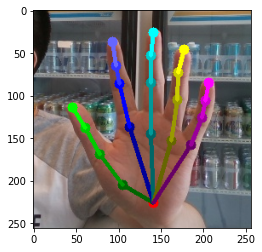

In [160]:
plt.imshow(skeleton_overlay.astype(np.uint8))

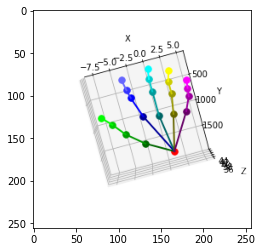

In [161]:
plt.imshow(skeleton_3d)

### check img features

In [134]:
pose_scale

tensor(5., device='cuda:0')

In [127]:
est_mesh_cam_xyz.shape

torch.Size([1, 1280, 3])

In [99]:
img_feature_test = np.array(est_hm_list[0][0][3].reshape(64, 64).detach().cpu())

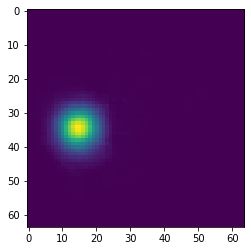

In [100]:
plt.imshow(img_feature_test)

In [70]:
bbox.shape

torch.Size([4])

In [71]:
root_depth.shape

torch.Size([])

In [74]:
pose_scales[0]

tensor(5., device='cuda:0')

### ----------------------------------------_

In [8]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
img = cv2.imread('./data/real_world_testset/images/00000.jpg')
thresh_img = np.zeros(img.shape[:2])
thresh_img[100:200, 100:200] = 255
thresh_img = cv2.cvtColor(thresh_img.astype(np.uint8), cv2.COLOR_GRAY2RGB)

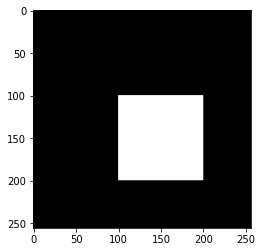

In [26]:
plt.imshow(thresh_img)

In [33]:
thresh = thresh_img > 100

In [34]:
pixels = np.where(thresh, img, thresh_img)

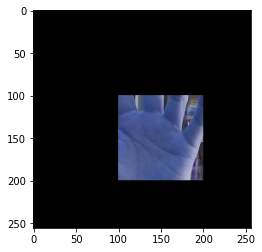

In [35]:
plt.imshow(pixels)

In [ ]:
#!/usr/local/bin/python3
from PIL import Image
import numpy as np

# Open the input image as numpy array
npImage=np.array(Image.open("image.jpg"))
# Open the mask image as numpy array
npMask=np.array(Image.open("mask2.jpg").convert("RGB"))

# Make a binary array identifying where the mask is black
cond = npMask<128

# Select image or mask according to condition array
pixels=np.where(cond, npImage, npMask)

# Save resulting image
result=Image.fromarray(pixels)
result.save('result.png')

# 2nd method : google

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [28]:
img = cv2.imread('./testimg.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

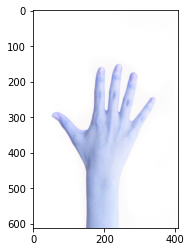

In [29]:
plt.imshow(img)

In [30]:
# For static images:
with mp_hands.Hands(min_detection_confidence=0.5) as hands:
    # Read an image, flip it around y-axis for correct handedness output (see
    # above).
    image = cv2.flip(img, 1)
    # Convert the BGR image to RGB before processing.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = hands.process(image)

    image.flags.writeable = True

    print(results.multi_hand_landmarks)

[landmark {
  x: 0.5138522982597351
  y: 0.7207803726196289
  z: -9.332048648502678e-05
}
landmark {
  x: 0.6278088092803955
  y: 0.6597937345504761
  z: 0.02207028865814209
}
landmark {
  x: 0.6954057812690735
  y: 0.5909955501556396
  z: 0.010820743627846241
}
landmark {
  x: 0.7589694857597351
  y: 0.5281009078025818
  z: 0.004927987232804298
}
landmark {
  x: 0.8290717601776123
  y: 0.48660042881965637
  z: -0.0031094306614249945
}
landmark {
  x: 0.540076732635498
  y: 0.5123685002326965
  z: -0.0986327975988388
}
landmark {
  x: 0.5376147031784058
  y: 0.39530739188194275
  z: -0.13107790052890778
}
landmark {
  x: 0.5365661382675171
  y: 0.32675203680992126
  z: -0.13497433066368103
}
landmark {
  x: 0.534591794013977
  y: 0.2781665325164795
  z: -0.13814060389995575
}
landmark {
  x: 0.4567698538303375
  y: 0.5189334750175476
  z: -0.09775635600090027
}
landmark {
  x: 0.4310288429260254
  y: 0.3950987756252289
  z: -0.1503731906414032
}
landmark {
  x: 0.41847702860832214
  y:

In [62]:
all_data = []

In [60]:
result_data = results.multi_hand_landmarks[0].landmark

In [68]:
all_data.append(result_data)

In [70]:
len(all_data)

3

In [51]:
result = [print(f"{lm.x}, {lm.y}, {lm.z}") for lm in results.multi_hand_landmarks[0].landmark]
print(len(result))

0.5138522982597351, 0.7207803726196289, -9.332048648502678e-05
0.6278088092803955, 0.6597937345504761, 0.02207028865814209
0.6954057812690735, 0.5909955501556396, 0.010820743627846241
0.7589694857597351, 0.5281009078025818, 0.004927987232804298
0.8290717601776123, 0.48660042881965637, -0.0031094306614249945
0.540076732635498, 0.5123685002326965, -0.0986327975988388
0.5376147031784058, 0.39530739188194275, -0.13107790052890778
0.5365661382675171, 0.32675203680992126, -0.13497433066368103
0.534591794013977, 0.2781665325164795, -0.13814060389995575
0.4567698538303375, 0.5189334750175476, -0.09775635600090027
0.4310288429260254, 0.3950987756252289, -0.1503731906414032
0.41847702860832214, 0.32020729780197144, -0.16134820878505707
0.4077971577644348, 0.2691633105278015, -0.170495867729187
0.38430726528167725, 0.541836142539978, -0.08880379796028137
0.338358074426651, 0.43182799220085144, -0.13484808802604675
0.3166169226169586, 0.35934585332870483, -0.14387600123882294
0.30538028478622437, 

In [71]:
import csv
with open('dataset.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['num', 'filename', 'joint', 'lmx', 'lmy', 'lmz'])
    for (i_data, data) in enumerate(all_data):
        for i_lm, lm in enumerate(data):
            writer.writerow([i_data, "hehe", i_lm, lm.x, lm.y, lm.z])

In [74]:
cv2.imwrite("./dataset/img/{0:04}.jpg".format(0), img)

True

<method 'count' of 'tuple' objects>

In [80]:
import os
import glob

In [162]:
path = './dataset'
num_gesture = 6

In [188]:
def diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

def create_dirs(path, list_dir):
    for (i, i_dir) in enumerate(gesture_dirs_not_exist):
        os.mkdir(os.path.join(path, 'gesture_{}'.format(i_dir)))
        
def count_data_dirs(path, gesture_i):
    data_num = [int(path[-1]) for path in glob.glob(os.path.join(path, f'gesture_{gesture_i}', 'data*'))]
    if(len(data_num) > 0):
        return max(data_num)
    else:
        return 0

In [189]:
gesture_dirs_exist = glob.glob(os.path.join(path, 'gesture_*'))
gesture_dirs_exist = [int(dirs[-1]) for dirs in gesture_dirs_exist]
target_gesture_dirs = [int(i_dir) for i_dir in range(1, num_gesture + 1)]
gesture_dirs_not_exist = diff(target_gesture_dirs, gesture_dirs_exist)

In [190]:
if(len(gesture_dirs_not_exist) > 0):
    create_dirs(path, gesture_dirs_not_exist)

In [196]:
gesture_data_count = [count_data_dirs(path, i) for i in target_gesture_dirs]

In [198]:
[i+1 for i in gesture_data_count]

[3, 3, 1, 1, 1, 1]

In [205]:
[print (i) for i in results.index]

TypeError: 'method_descriptor' object is not iterable

In [230]:
len(results.multi_hand_landmarks[0].landmark)

21

In [221]:
x = results.multi_hand_landmarks[0].landmark[0].x
y = results.multi_hand_landmarks[0].landmark[0].y
z = results.multi_hand_landmarks[0].landmark[0].z

In [210]:
from typing import List, Tuple, Union

In [222]:
img.shape

(612, 408, 3)

In [224]:
import math

In [227]:
def _normalized_to_pixel_coordinates(normalized_x: float, normalized_y: float, \
                                     image_width: int, image_height: int) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""
    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

    if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
        # TODO: Draw coordinates even if it's outside of the image bounds.
        return None
    
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px

In [228]:
_normalized_to_pixel_coordinates(x, y, 408, 612)

(209, 441)

### =========================================================

In [12]:
!python stream.py --device-type realsense --record

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
FPS : 1.24
FPS : 68.60
FPS : 49.29
FPS : 51.08
FPS : 30.12
FPS : 29.90
FPS : 27.38
FPS : 33.23
FPS : 28.14
FPS : 30.93
FPS : 29.88
FPS : 31.62
FPS : 24.55
FPS : 37.12
FPS : 30.79
FPS : 9.15
FPS : 87.85
FPS : 89.41
FPS : 78.31
FPS : 37.44
FPS : 35.08
FPS : 42.03
FPS : 37.26
FPS : 37.71
FPS : 35.70
FPS : 38.16
FPS : 40.11
FPS : 38.85
FPS : 37.66
FPS : 37.53
FPS : 36.64
FPS : 38.20
FPS : 35.41
FPS : 37.74
FPS : 33.20
FPS : 44.97
FPS : 34.25
FPS : 42.14
FPS : 35.84
FPS : 40.58
FPS : 37.75
FPS : 17.02
FPS : 69.25
FPS : 76.00
FPS : 25.53
FPS : 62.95
FPS : 54.47
FPS : 18.75
FPS : 66.57
FPS : 86.73
FPS : 37.83
FPS : 38.44
FPS : 39.25
FPS : 17.54
FPS : 51.53
FPS : 91.22
FPS : 53.97
FPS : 37.28
FPS : 18.16
FPS : 56.44
FPS : 56.74
FPS : 62.76
FPS : 19.22
FPS : 71.32
FPS : 63.31
FPS : 40.40
FPS : 38.91
FPS : 36.55
FPS : 37.39
FPS : 19.12
FPS : 66.13
FPS : 77.62
FPS : 37.75
FPS : 38.67
FPS : 35.01
FPS : 39.71
FPS : 38.20
FPS : 39.32
FPS : 37.3

In [176]:
import glob
import numpy as np
import csv
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
id_list = [[int(string.split('/')[2][8:]), int(string.split('/')[3][4:])] for string in glob.glob('./dataset/gesture_*/data*')]

In [182]:
id_list

[[6, 10],
 [6, 8],
 [6, 13],
 [6, 11],
 [6, 2],
 [6, 7],
 [6, 4],
 [6, 3],
 [6, 5],
 [6, 1],
 [6, 9],
 [6, 12],
 [6, 6],
 [4, 10],
 [4, 8],
 [4, 11],
 [4, 2],
 [4, 7],
 [4, 4],
 [4, 3],
 [4, 5],
 [4, 1],
 [4, 9],
 [4, 12],
 [4, 6],
 [1, 10],
 [1, 8],
 [1, 13],
 [1, 11],
 [1, 2],
 [1, 7],
 [1, 4],
 [1, 3],
 [1, 15],
 [1, 5],
 [1, 1],
 [1, 9],
 [1, 14],
 [1, 12],
 [1, 6],
 [3, 8],
 [3, 13],
 [3, 11],
 [3, 2],
 [3, 7],
 [3, 4],
 [3, 3],
 [3, 15],
 [3, 5],
 [3, 1],
 [3, 14],
 [3, 12],
 [3, 6],
 [2, 10],
 [2, 8],
 [2, 13],
 [2, 11],
 [2, 2],
 [2, 7],
 [2, 4],
 [2, 3],
 [2, 5],
 [2, 1],
 [2, 9],
 [2, 12],
 [2, 6],
 [5, 10],
 [5, 8],
 [5, 11],
 [5, 2],
 [5, 7],
 [5, 4],
 [5, 3],
 [5, 5],
 [5, 1],
 [5, 9],
 [5, 12],
 [5, 6]]

In [173]:
id_arr = np.array(id_list)
id_arr = id_arr[np.lexsort(np.fliplr(id_arr).T)]

In [175]:
id_arr[0]

array([1, 0])

In [174]:
len(id_arr)

78

In [17]:
for id in id_arr:
    gesture_id, data_id = id
    csv_dir = os.path.join('.', 'dataset', f'gesture_{gesture_id}', f'data{data_id}')
    print(csv_dir)

./dataset/gesture_1/data0
./dataset/gesture_1/data1
./dataset/gesture_1/data1
./dataset/gesture_1/data2
./dataset/gesture_1/data2
./dataset/gesture_1/data3
./dataset/gesture_1/data3
./dataset/gesture_1/data4
./dataset/gesture_1/data4
./dataset/gesture_1/data5
./dataset/gesture_1/data5
./dataset/gesture_1/data6
./dataset/gesture_1/data7
./dataset/gesture_1/data8
./dataset/gesture_1/data9
./dataset/gesture_2/data0
./dataset/gesture_2/data1
./dataset/gesture_2/data1
./dataset/gesture_2/data2
./dataset/gesture_2/data2
./dataset/gesture_2/data3
./dataset/gesture_2/data3
./dataset/gesture_2/data4
./dataset/gesture_2/data5
./dataset/gesture_2/data6
./dataset/gesture_2/data7
./dataset/gesture_2/data8
./dataset/gesture_2/data9
./dataset/gesture_3/data1
./dataset/gesture_3/data1
./dataset/gesture_3/data2
./dataset/gesture_3/data2
./dataset/gesture_3/data3
./dataset/gesture_3/data3
./dataset/gesture_3/data4
./dataset/gesture_3/data4
./dataset/gesture_3/data5
./dataset/gesture_3/data5
./dataset/ge

In [38]:
gesture_id = 1
data_id = 1
csv_filename = []
csv_isincluded = []
csv_x, csv_y, csv_z, csv_u, csv_v = [], [], [], [], []
csv_x_arr, csv_y_arr, csv_z_arr, csv_u_arr, csv_v_arr = [], [], [], [], []

path = os.path.join('.', 'dataset', f'gesture_{gesture_id}', f'data{data_id}')
with open(os.path.join(path, 'skeleton.csv')) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for i, row in enumerate(csv_reader):
        if(i > 0):
            csv_x_arr.append(row[2])
            csv_y_arr.append(row[3])
            csv_z_arr.append(row[4])
            csv_u_arr.append(row[5])
            csv_v_arr.append(row[6])
            csv_isincluded_arr.append(row[7])
            if((i) % 21 == 0):
                csv_filename.append(row[0])
                csv_isincluded.append(row[7])
                csv_x.append(csv_x_arr)
                csv_y.append(csv_y_arr)
                csv_z.append(csv_z_arr)
                csv_u.append(csv_u_arr)
                csv_v.append(csv_v_arr)
                csv_x_arr, csv_y_arr, csv_z_arr, csv_u_arr, \
                    csv_v_arr = [], [], [], [], []

In [39]:
csv_isincluded

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1']

In [160]:
path = os.path.join('.', 'dataset', f'gesture_{gesture_id}', f'data{data_id}', csv_filename[0])
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [161]:
circle_radius: int = 2
color = (255, 0, 0)
linecolor = (0, 255, 0)
thickness: int = 2
line_thickness: int = 1

In [162]:
connections = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [0, 17], 
               [5, 9], [9, 13], [13, 17], [5, 6], [6, 7], [7, 8], 
               [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16], 
               [17, 18], [18, 19], [19, 20]]

In [163]:
for i in range(len(connections)):
    cv2.line(img, 
             (int(csv_u[0][connections[i][0]]), int(csv_v[0][connections[i][0]])), 
             (int(csv_u[0][connections[i][1]]), int(csv_v[0][connections[i][1]])),
             linecolor, 
             line_thickness)
for i in range(len(connections)):
    cv2.circle(img, (int(csv_u[0][i]), int(csv_v[0][i])), circle_radius, color, thickness)

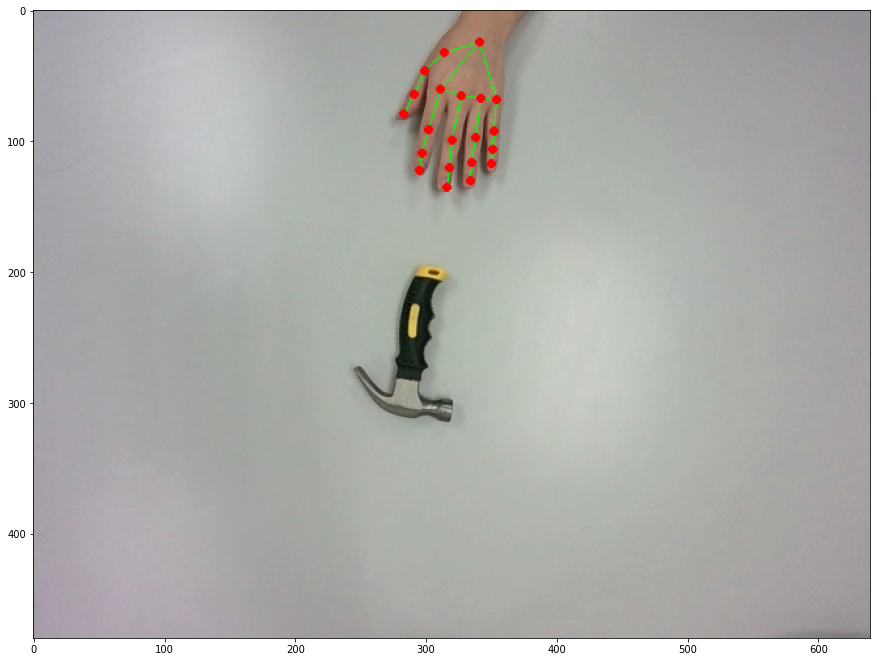

In [164]:
plt.figure(figsize=(15,15))
plt.imshow(img)

In [106]:
csv_u[0][connections[0][0]]

'341'

In [110]:
i = 0
print(int(csv_u[0][connections[i][0]]), int(csv_v[0][connections[i][0]]))
print(int(csv_u[0][connections[i][1]]), int(csv_v[0][connections[i][1]]))

341 24
314 32


In [72]:
int(csv_v[0][connections[i][1]])

32

In [ ]:
cv2.circle(image, px, landmark_drawing_spec.circle_radius, landmark_drawing_spec.color, landmark_drawing_spec.thickness)

In [ ]:
circle_radius: int = 2
color: Tuple[int, int, int] = (0, 255, 0)
thickness: int = 2

    cv2.circle(image, px, landmark_drawing_spec.circle_radius,
               landmark_drawing_spec.color, landmark_drawing_spec.thickness)

        cv2.line(image, idx_to_coordinates[start_idx],
                 idx_to_coordinates[end_idx], connection_drawing_spec.color,
                 connection_drawing_spec.thickness)

In [2]:
## =================== INFERENCE MODEL ==========================+

In [15]:
from model.network import DG_STA
import torch
import numpy as np
from train_on_custom import init_model, model_foreward
import argparse
import torch.optim as optim

In [44]:
class_num = 6
dp_rate = 0.2
model = DG_STA(class_num, dp_rate)
model = torch.load('./model/dp-0.2_lr-0.0001_dc-0/epoch_13_acc_1.0.pth')

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("-b", "--batch_size", type=int, default=32)  # 16
parser.add_argument("-lr", "--learning_rate", type=float, default=1e-3)
parser.add_argument('--cuda', default=True, help='enables cuda')
parser.add_argument('-j', '--workers', default=8, type=int, metavar='N',
                    help='number of data loading workers (default: 8)')
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run')  # 1000

parser.add_argument('--patiences', default=50, type=int,
                    help='number of epochs to tolerate the no improvement of val_loss')  # 1000


parser.add_argument('--data_cfg', type=int, default=0,
                    help='0 for 14 class, 1 for 28')


parser.add_argument('--dp_rate', type=float, default=0.2,
                    help='dropout rate')  # 1000

args = parser.parse_args('')

In [12]:
model = init_model(args)
model_solver = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=args.learning_rate)

model.load_state_dict(torch.load('./model/dp-0.2_lr-0.0001_dc-0/epoch_13_acc_1.0.pth'))
# model.eval()

criterion = torch.nn.CrossEntropyLoss()

In [73]:
sample_batched = torch.from_numpy(np.ones([1, 8, 21, 3])).float()
# sample_batched = torch.zeros([1, 8, 21, 3]).float()

In [75]:
score = model(sample_batched)

In [65]:
score

tensor([[-1.7286,  1.6355,  1.7610,  1.2591, -0.6726, -1.1524]],
       device='cuda:0', grad_fn=<AddmmBackward>)